# DeepHack course on RL. Assignment 4.
# MC. TD. TD($\lambda$)

In [1]:
import matplotlib.pyplot as plt
from IPython.display import display
from gym import wrappers
import numpy as np

import gym
%matplotlib inline

We will use the frozen-lake environment

In [2]:
env = gym.make('FrozenLake8x8-v0')

INFO:gym.envs.registration:Making new env: FrozenLake8x8-v0
[2017-01-03 02:48:45,266] Making new env: FrozenLake8x8-v0


Our goal will be to approximate the value function for the fully-random policy, using three different techniques.

## Monte Carlo
This method uses the following update formula.

$$v(s_t) = v(s_t) + \frac 1 {N(s_t)}(G_t - v(s_t)),$$

where $v$ is the value function, $N(s_t)$ is the number of times the state $s_t$ has been visited and $G_t$ is the return at time step $t$. The method operates as follows. We observe trajectories for the given policy (in case of the on-policy method, which we consider here), and after the end of an episode, we update the value function, according to the specified rule, using the observed values of $G_t$.

Let's look, how many times we visit each state for 1000 episodes.

In [3]:
n_runs = 1000
num_visited = np.zeros((env.nS, 1))
for i_episode in range(n_runs):
    num_visited_cur = np.zeros((env.nS, 1))
    observation = env.reset()
    num_visited_cur[observation] = 1
    if not i_episode % 100:
        print('Playing episode:', i_episode)
    for t in range(500):
        
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        num_visited_cur[observation] = 1
        if done:
#             print("Episode finished after {} timesteps".format(t+1))
            break
    num_visited += num_visited_cur
    

Playing episode: 0
Playing episode: 100
Playing episode: 200
Playing episode: 300
Playing episode: 400
Playing episode: 500
Playing episode: 600
Playing episode: 700
Playing episode: 800
Playing episode: 900


In [4]:
num_visited.reshape((8,8))

array([[ 1000.,   825.,   573.,   380.,   225.,   141.,    85.,    61.],
       [  815.,   784.,   604.,   409.,   244.,   151.,    87.,    71.],
       [  582.,   598.,   516.,   524.,   131.,   116.,    68.,    67.],
       [  392.,   427.,   315.,   116.,    71.,    95.,    53.,    41.],
       [  249.,   262.,   199.,   108.,    18.,     6.,    27.,    23.],
       [  131.,   156.,    58.,     1.,     2.,     1.,    16.,    11.],
       [   50.,    35.,     4.,     0.,     1.,     0.,     1.,     6.],
       [   25.,    15.,     9.,     4.,     0.,     0.,     0.,     2.]])

Let's load the actual value function of the completely random policy, computed by DP.

In [6]:
true_v = np.load('true_value.npy')

Now we will implement the MC method for the frozen-lake problem. In this problem $G_t = r_T$, as $\gamma = 1$ and intermediate rewards are all 0. This means, that we set $v(s)$ to be equal to the fraction of trajectories passing through $s$, that did end up in the goal state.

In [7]:
def MC(n_runs, print_freq=0.1, v0=None, true_v=None, policy=None):
    norms = []
    v = v0 or np.zeros((env.nS, 1))
    n_visited = np.zeros_like(v)
    if true_v is not None:
        v[env.nS-1] = 0
        norms.append(np.linalg.norm(v - true_v))
    for i_episode in range(n_runs):
        visited_cur = np.zeros((env.nS, 1))
        observation = env.reset()
        num_visited_cur[observation] = 1
        if not i_episode % int(n_runs * print_freq):
            print('Playing episode:', i_episode)
        
        for t in range(500):
            if policy is None:
                action = env.action_space.sample()
            else:
                action = np.random.choice(env.nA, p=eps_optimal_policy[observation])
            observation, reward, done, info = env.step(action)
            visited_cur[observation] = 1
            if done:
                break
                
        n_visited += visited_cur
        v[np.where(visited_cur)] += 1/n_visited[np.where(visited_cur)] * (reward - v[np.where(visited_cur)])
        if true_v is not None:
            v[env.nS-1] = 0
            norms.append(np.linalg.norm(v - true_v))
    v[env.nS-1] = 0
    if true_v is not None:
        return v, norms
    return v

We will evaluate the method on the completely random policy.

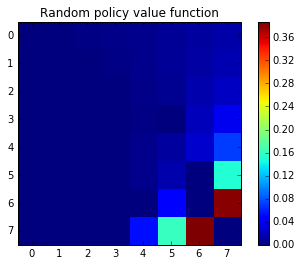

In [17]:
plt.imshow(true_v.reshape((8,8)), interpolation='nearest')
plt.colorbar()
plt.title('Random policy value function')

Let's run the method

In [9]:
v_rnd_mc, norms_rnd_mc = MC(n_runs=100000, true_v=true_v)

Playing episode: 0
Playing episode: 10000
Playing episode: 20000
Playing episode: 30000
Playing episode: 40000
Playing episode: 50000
Playing episode: 60000
Playing episode: 70000
Playing episode: 80000
Playing episode: 90000


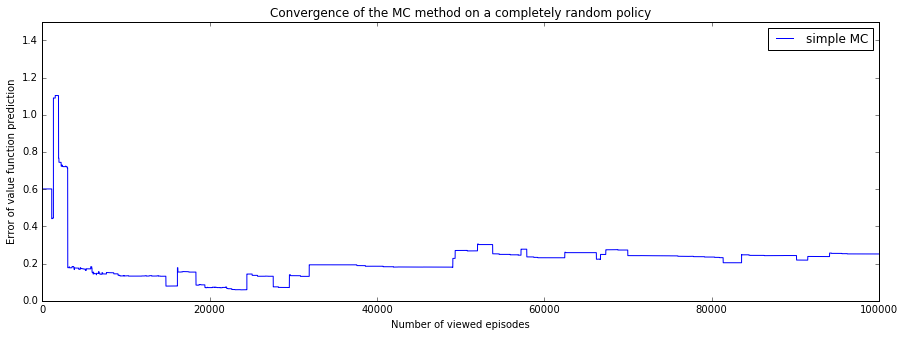

In [12]:
plt.figure(figsize=(15, 5))
plt.plot(norms_rnd_mc, label='simple MC')
plt.ylabel('Error of value function prediction')
plt.xlabel('Number of viewed episodes')
plt.ylim([0., 1.5])
plt.title('Convergence of the MC method on a completely random policy')
plt.legend()

Now let's see how MC approximates the value function of an almost optimal policy

In [13]:
eps_optimal_policy = np.load('eps_opt_pi.npy')
eps_optimal_v = np.load('eps_opt_v.npy')

It's true value function looks like this.

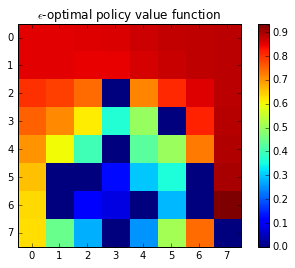

In [16]:
plt.imshow(eps_optimal_v.reshape((8,8)), interpolation='nearest')
plt.colorbar()
plt.title('$\epsilon$-optimal policy value function')

In [18]:
v_opt_mc, norms_opt_mc = MC(n_runs=100000, true_v=eps_optimal_v, policy=eps_optimal_policy)

Playing episode: 0
Playing episode: 10000
Playing episode: 20000
Playing episode: 30000
Playing episode: 40000
Playing episode: 50000
Playing episode: 60000
Playing episode: 70000
Playing episode: 80000
Playing episode: 90000


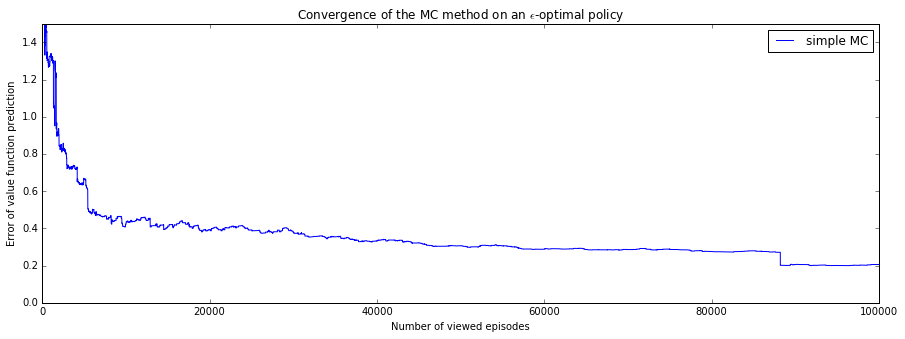

In [21]:
plt.figure(figsize=(15, 5))
plt.plot(norms_opt_mc, label='simple MC')
plt.ylabel('Error of value function prediction')
plt.xlabel('Number of viewed episodes')
plt.ylim([0., 1.5])
plt.title('Convergence of the MC method on an $\epsilon$-optimal policy')
plt.legend()

Below we will only use the completely random policy.

#### Constant-$\alpha$ MC

This method uses the following update formula.

$$v(s_t) = v(s_t) + \alpha(G_t - v(s_t)).$$

This method would still converge for a good value of $\alpha$ in case of a slowly changing environment.

In [22]:
def constant_alpha_MC(n_runs, alpha, print_freq=0.1, v0=None, true_v=None):
    norms = []
    v = v0 or np.zeros((env.nS, 1))
    if true_v is not None:
        v[env.nS-1] = 0
        norms.append(np.linalg.norm(v - true_v))
    for i_episode in range(n_runs):
        visited_cur = np.zeros((env.nS, 1))
        observation = env.reset()
        num_visited_cur[observation] = 1
        if not i_episode % int(n_runs * print_freq):
            print('Playing episode:', i_episode)
        
        for t in range(500):
            action = env.action_space.sample()
            observation, reward, done, info = env.step(action)
            visited_cur[observation] = 1
            if done:
                break
        v[np.where(visited_cur)] += alpha * (reward - v[np.where(visited_cur)])
        if true_v is not None:
            v[env.nS-1] = 0
            norms.append(np.linalg.norm(v - true_v))
    v[env.nS-1] = 0
    if true_v is not None:
        return v, norms
    return v
    

Let us run the method with different alpha and compare performance.

In [23]:
norms_alpha = []
alpha_lst = [.3, .1, .05, 1e-2]
for alpha in alpha_lst:
    print('\talpha=',alpha)
    v, norms = constant_alpha_MC(n_runs=100000, alpha=alpha, true_v=true_v)
    norms_alpha.append(norms)
norms_amc = norms_alpha
alphas_amc = alpha_lst

	alpha= 0.3
Playing episode: 0
Playing episode: 10000
Playing episode: 20000
Playing episode: 30000
Playing episode: 40000
Playing episode: 50000
Playing episode: 60000
Playing episode: 70000
Playing episode: 80000
Playing episode: 90000
	alpha= 0.1
Playing episode: 0
Playing episode: 10000
Playing episode: 20000
Playing episode: 30000
Playing episode: 40000
Playing episode: 50000
Playing episode: 60000
Playing episode: 70000
Playing episode: 80000
Playing episode: 90000
	alpha= 0.05
Playing episode: 0
Playing episode: 10000
Playing episode: 20000
Playing episode: 30000
Playing episode: 40000
Playing episode: 50000
Playing episode: 60000
Playing episode: 70000
Playing episode: 80000
Playing episode: 90000
	alpha= 0.01
Playing episode: 0
Playing episode: 10000
Playing episode: 20000
Playing episode: 30000
Playing episode: 40000
Playing episode: 50000
Playing episode: 60000
Playing episode: 70000
Playing episode: 80000
Playing episode: 90000


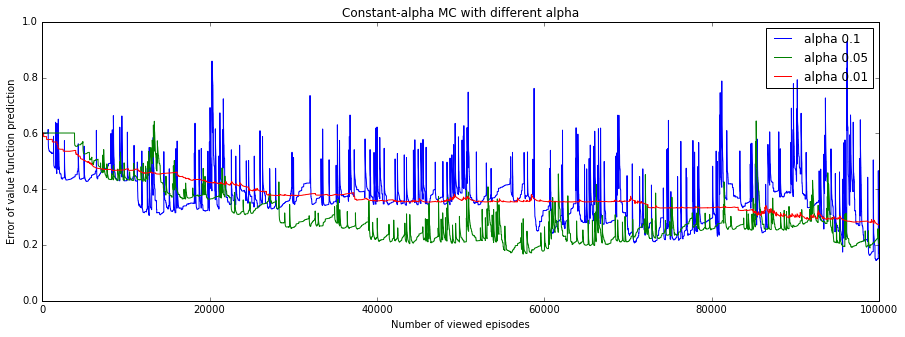

In [29]:
plt.figure(figsize=(15, 5))
for norms, alpha in list(zip(norms_amc, alphas_amc))[1:]:
    plt.plot(norms, label='alpha '+str(alpha))
plt.ylabel('Error of value function prediction')
plt.xlabel('Number of viewed episodes')
plt.ylim([0., 1.])
plt.title('Constant-alpha MC with different alpha')
plt.legend()

In [45]:
best_norms_amc = norms_amc[2]
best_alpha_amc = alphas_amc[2]

Let us compare the best result with simple MC.

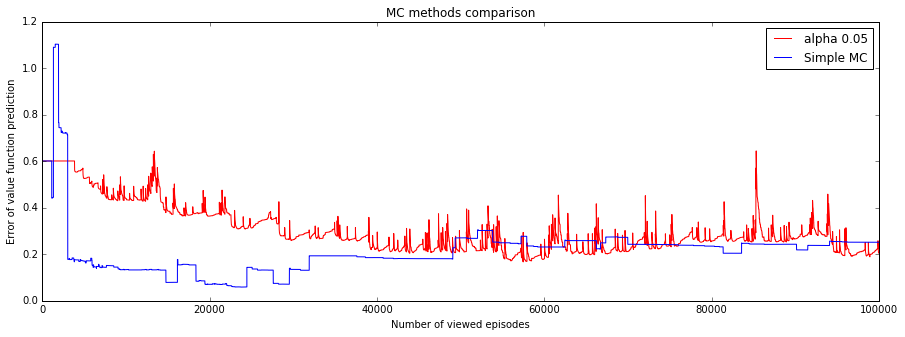

In [46]:
plt.figure(figsize=(15, 5))
plt.plot(best_norms_amc, 'r', label='alpha '+str(best_alpha_amc))
plt.plot(norms_rnd_mc, 'b', label='Simple MC')
plt.ylabel('Error of value function prediction')
plt.xlabel('Number of viewed episodes')
plt.title('MC methods comparison')
plt.legend()

## Temporal-Difference
This method is similar to constant-$\alpha$ MC, but it "bootstraps". The update rule is given by

$v(s_t) = v(s_t) + \alpha\left(r_{t+1} + \gamma v(s_{t+1}) - v(s_t)\right).$

Here we implement the offline method, meaning that we make updates only after the episode is finished.

In [40]:
def td(n_runs, alpha, print_freq=0.1, v0=None, true_v=None):
    norms = []
    v = v0 or np.zeros((env.nS, 1))
    if true_v is not None:
        norms.append(np.linalg.norm(v - true_v))
    for i_episode in range(n_runs):
        observation = env.reset()
        num_visited_cur[observation] = 1
        if not i_episode % int(n_runs * print_freq):
            print('Playing episode:', i_episode)
        
        new_v = np.copy(v)
        for t in range(500):
            action = env.action_space.sample()
            old_observation = observation
            observation, reward, done, info = env.step(action)
            
            new_v[old_observation] += alpha * (reward + v[observation] - v[old_observation])
            if done:
                break
        v = new_v
        if true_v is not None:
            norms.append(np.linalg.norm(v - true_v))
    if true_v is not None:
        return v, norms
    return v

Now let's compare the method's performance on our problem for different alphas.

In [41]:
norms_alpha = []
alpha_lst = [.3, .1, .05, 1e-2]
for alpha in alpha_lst:
    print('\talpha=',alpha)
    v, norms = td(n_runs=100000, alpha=alpha, true_v=true_v)
    norms_alpha.append(norms)
norms_td = norms_alpha
alphas_td = alpha_lst

	alpha= 0.3
Playing episode: 0
Playing episode: 10000
Playing episode: 20000
Playing episode: 30000
Playing episode: 40000
Playing episode: 50000
Playing episode: 60000
Playing episode: 70000
Playing episode: 80000
Playing episode: 90000
	alpha= 0.1
Playing episode: 0
Playing episode: 10000
Playing episode: 20000
Playing episode: 30000
Playing episode: 40000
Playing episode: 50000
Playing episode: 60000
Playing episode: 70000
Playing episode: 80000
Playing episode: 90000
	alpha= 0.05
Playing episode: 0
Playing episode: 10000
Playing episode: 20000
Playing episode: 30000
Playing episode: 40000
Playing episode: 50000
Playing episode: 60000
Playing episode: 70000
Playing episode: 80000
Playing episode: 90000
	alpha= 0.01
Playing episode: 0
Playing episode: 10000
Playing episode: 20000
Playing episode: 30000
Playing episode: 40000
Playing episode: 50000
Playing episode: 60000
Playing episode: 70000
Playing episode: 80000
Playing episode: 90000


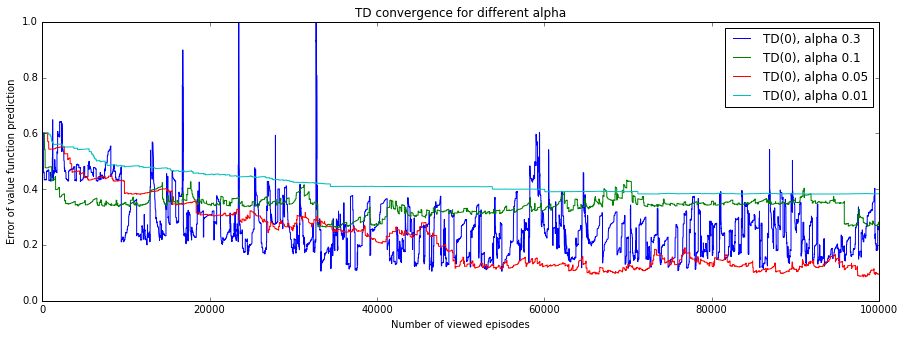

In [43]:
plt.figure(figsize=(15,5))
for norms, alpha in list(zip(norms_td, alphas_td)):
    plt.plot(norms, label='TD(0), alpha '+str(alpha))
plt.ylabel('Error of value function prediction')
plt.ylim([0., 1.])
plt.xlabel('Number of viewed episodes')
plt.legend()
plt.title('TD convergence for different alpha')

In [48]:
best_norms_td = norms_td[2]
best_alpha_td = alphas_td[2]

Finally, let's compare it with MC methods

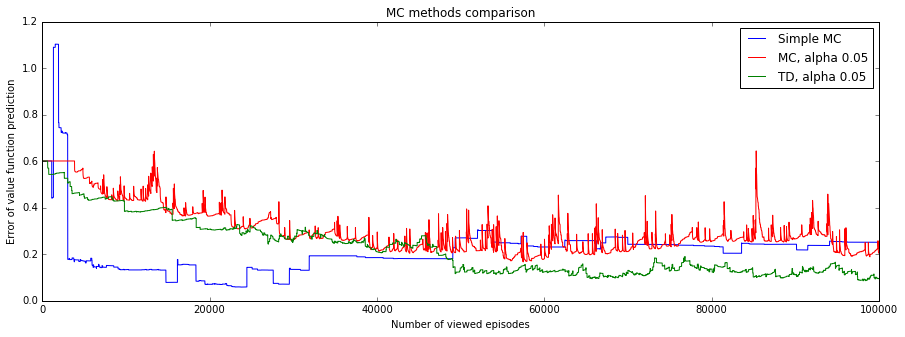

In [50]:
plt.figure(figsize=(15, 5))
plt.plot(norms_rnd_mc, 'b', label='Simple MC')
plt.plot(best_norms_amc, 'r', label='MC, alpha '+str(best_alpha_amc))
plt.plot(best_norms_td, 'g', label='TD, alpha '+str(best_alpha_td))
plt.ylabel('Error of value function prediction')
plt.xlabel('Number of viewed episodes')
plt.title('MC methods comparison')
plt.legend()

###n-step bootstrapping
Instead of simple TD we could use multy-step bootstrapping.
$$v(s_t) = v(s_t) + \alpha (G_t^{(n)} - v(s_t)),$$
where
$$G^{(n)}_t = r_{t+1} + \gamma r_{t+2} + \ldots + \gamma^{n-1} r_{t+n} + \gamma^n v(s_{t+n}).$$

Obviously, we can perform the update of $v(s_t)$ only after iteration $t + n$ then.

Note that for $n=1$ we get the TD method and for $n = T - t$ we get the Mc method.

Below we implement an online version of this method, meaning that we update the values $v$ as soon, as we can, not waiting until the end of the episode.

In our case the rewards are all zero,  except we finished the game. We also use $\gamma = 1$. This makes the update rule
$$v(s_t) = v(s_t) + \alpha (v(s_{t+n}) - v(s_t))$$
for $t$, such that $t+n < T$. For other $t$ we get
$$v(s_t) = v(s_t) + \alpha (r_T - v(s_t)),$$
so the update for late steps is the same as in MC.

In [45]:
def td_n_step(n_runs, alpha, n_step, print_freq=0.1, v0=None, true_v=None):
    norms = []
    v = v0 or np.zeros((env.nS, 1))
    if true_v is not None:
        norms.append(np.linalg.norm(v - true_v))
    for i_episode in range(n_runs):
        observation = env.reset()
        num_visited_cur[observation] = 1
        state_seq = [observation]
        if not i_episode % int(n_runs * print_freq):
            print('Playing episode:', i_episode)
        
        for t in range(500):
            action = env.action_space.sample()    
            observation, reward, done, info = env.step(action)            
            if done:
                for k in range(n_step):
                    v[state_seq[-n_step + k]] += alpha * (reward - v[state_seq[-n_step + k]])
                break
 
            if t >= n_step:
                v[state_seq[-n_step]] += alpha * (v[observation] - v[state_seq[-n_step]])
            state_seq.append(observation)
        if true_v is not None:
            norms.append(np.linalg.norm(v - true_v))
    if true_v is not None:
        return v, norms
    return v

Let's run the method for n=5

In [51]:
norms_alpha = []
alpha_lst = [.3, .1, 1e-2, 1e-3]
for alpha in alpha_lst:
    print('\talpha=',alpha)
    v, norms = td_n_step(n_runs=100000, n_step=5, alpha=alpha, true_v=true_v)
    norms_alpha.append(norms)

	alpha= 0.3
Playing episode: 0
Playing episode: 10000
Playing episode: 20000
Playing episode: 30000
Playing episode: 40000
Playing episode: 50000
Playing episode: 60000
Playing episode: 70000
Playing episode: 80000
Playing episode: 90000
	alpha= 0.1
Playing episode: 0
Playing episode: 10000
Playing episode: 20000
Playing episode: 30000
Playing episode: 40000
Playing episode: 50000
Playing episode: 60000
Playing episode: 70000
Playing episode: 80000
Playing episode: 90000
	alpha= 0.01
Playing episode: 0
Playing episode: 10000
Playing episode: 20000
Playing episode: 30000
Playing episode: 40000
Playing episode: 50000
Playing episode: 60000
Playing episode: 70000
Playing episode: 80000
Playing episode: 90000
	alpha= 0.001
Playing episode: 0
Playing episode: 10000
Playing episode: 20000
Playing episode: 30000
Playing episode: 40000
Playing episode: 50000
Playing episode: 60000
Playing episode: 70000
Playing episode: 80000
Playing episode: 90000


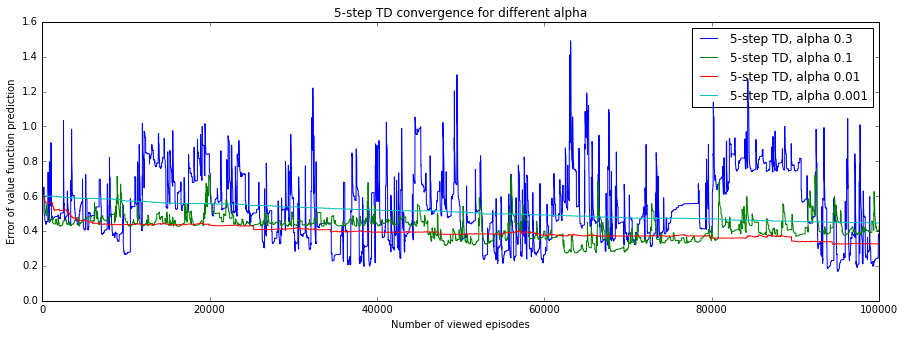

In [53]:
plt.figure(figsize=(15,5))
for norms, alpha in list(zip(norms_alpha, alpha_lst)):
    plt.plot(norms, label='5-step TD, alpha '+str(alpha))
plt.ylabel('Error of value function prediction')
plt.xlabel('Number of viewed episodes')
plt.legend()
plt.title('5-step TD convergence for different alpha')

## TD($\lambda$)
TD($\lambda$) method uses an average of $n$-step returns

$$G^{(n)}_t = r_{t+1} + \gamma r_{t+2} + \ldots + \gamma^{n-1} r_{t+n} + \gamma^n v(s_{t+n}).$$

The $\lambda$-return is defined by 

$$G^{\lambda}_t = (1 - \lambda \sum\limits_{n=1}^{\infty} \lambda^{n-1}G_t^n) = (1 - \lambda \sum\limits_{n=1}^{T - t - 1} \lambda^{n-1}G_t^n) + \lambda^{T - t - 1} G_t,$$
where $T$ is the terminal state.

The method is then defined by
$$v(s_t) = v(s_t) + \alpha \left(G_t^{\lambda} - v(s_t)\right).$$
Note that for $\lambda = 0$ we get the TD method and for $\lambda = 1$ we get the constant-$\alpha$ MC method.
